In [80]:
from pathlib import Path
import numpy as np
import json
from time import time_ns
import numpy as np
from typing import Dict, Tuple
from time import time_ns
import math

# ---------------------------
# INPUTS (match user's simple style)
# ---------------------------
EXP_RIDERSHIP = {
    'Lakeshore West': 33239,
    'Lakeshore East': 25769,
    'Kitchener': 15071,
    'Milton': 13138,
    'Barrie': 8636,
    'Stouffville': 7341,
    'Richmond Hill': 4642
}

INTERVAL_SIZE = 5  # minutes, window is 4:00–6:00 PM (120 total)

# PROFILES:
# - Each profile has parameters tuned for realistic patterns.
# - global_scale: overall multiplier for the totals in EXP_RIDERSHIP
# - line_scales: per-line multipliers (e.g., CNE -> Lakeshore boost)
# - spread: random noise as fraction of per-interval mean
# - shape: "gaussian" or "beta"
# - peak_time_min/peak_width_min: Gaussian timing
# - beta_a/beta_b: Beta curve shape
# NOTE: These are intentionally different across 10 instances (Mon–Sun + Christmas + CNE + Valentines)
PROFILES = {
    "Monday":     {"seed": 101, "global_scale": 0.95, "spread": 0.10, "shape": "gaussian", "peak_time_min": 70, "peak_width_min": 26, "line_scales": {}},
    "Tuesday":    {"seed": 102, "global_scale": 1.05, "spread": 0.10, "shape": "gaussian", "peak_time_min": 75, "peak_width_min": 22, "line_scales": {}},
    "Wednesday":  {"seed": 103, "global_scale": 1.15, "spread": 0.10, "shape": "gaussian", "peak_time_min": 75, "peak_width_min": 22, "line_scales": {}},
    "Thursday":   {"seed": 104, "global_scale": 1.06, "spread": 0.10, "shape": "gaussian", "peak_time_min": 80, "peak_width_min": 24, "line_scales": {}},
    "Friday":     {"seed": 105, "global_scale": 0.88, "spread": 0.11, "shape": "gaussian", "peak_time_min": 60, "peak_width_min": 28, "line_scales": {}},
    "Saturday":   {"seed": 106, "global_scale": 0.55, "spread": 0.12, "shape": "gaussian", "peak_time_min": 90, "peak_width_min": 36, "line_scales": {}},
    "Sunday":     {"seed": 107, "global_scale": 0.50, "spread": 0.12, "shape": "gaussian", "peak_time_min": 85, "peak_width_min": 36, "line_scales": {}},
    "Christmas":  {"seed": 201, "global_scale": 1.2, "spread": 0.08, "shape": "gaussian", "peak_time_min": 60, "peak_width_min": 50, "line_scales": {}},
    "CNE":        {"seed": 202, "global_scale": 1.30, "spread": 0.2, "shape": "gaussian", "peak_time_min": 95, "peak_width_min": 22,
                   "line_scales": {'Lakeshore West': 1.60, 'Lakeshore East': 1.40}},
    "Valentines": {"seed": 203, "global_scale": 1.2, "spread": 0.2, "shape": "gaussian", "peak_time_min": 10, "peak_width_min": 26,
                   "line_scales": {'Lakeshore West': 1.03, 'Lakeshore East': 1.03}},
}

# ---------------------------
# HELPERS (simple procedural functions)
# ---------------------------

def time_labels(interval_size):
    labels = []
    for t in range(0, 120, interval_size):
        hour = 4 + (t // 60)
        minute = t % 60
        labels.append(f"{hour}:{minute:02d}")
    return labels

def gaussian_curve(num_points, peak_idx, width_pts):
    x = np.arange(num_points)
    curve = np.exp(-0.5 * ((x - peak_idx) / max(width_pts, 1e-6))**2)
    s = curve.sum()
    if s == 0:
        curve = np.ones(num_points)
        s = curve.sum()
    return curve / s

def beta_curve(num_points, a, b):
    x = np.linspace(0, 1, num_points)
    a = max(a, 0.1); b = max(b, 0.1)
    curve = (x**(a-1)) * ((1-x)**(b-1))
    curve[np.isnan(curve)] = 0
    s = curve.sum()
    if s == 0:
        curve = np.ones(num_points)
        s = curve.sum()
    return curve / s

def build_curve(shape, interval_size, peak_time_min=75, peak_width_min=24, beta_a=3.0, beta_b=3.0):
    num_points = 120 // interval_size
    if shape == "gaussian":
        peak_idx = int(round(peak_time_min / interval_size))
        width_pts = max(1, int(round(peak_width_min / interval_size)))
        return gaussian_curve(num_points, peak_idx, width_pts)
    elif shape == "beta":
        return beta_curve(num_points, beta_a, beta_b)
    else:
        raise ValueError("shape must be 'gaussian' or 'beta'")

# ---------------------------
# ---------------------------

def generate_scenario(seed=None, interval_size=INTERVAL_SIZE, global_scale=1.0, spread=0.10,
                      shape="gaussian", peak_time_min=75, peak_width_min=24, beta_a=3.0, beta_b=3.0,
                      line_scales=None):
    if seed is None:
        seed = time_ns()
    if not isinstance(seed, int):
        seed = sum(ord(c) for c in str(seed))
    np.random.seed(seed % (2**32 - 1))

    if line_scales is None:
        line_scales = {}

    labels = time_labels(interval_size)
    curve = build_curve(shape, interval_size, peak_time_min, peak_width_min, beta_a, beta_b)

    scenario = {}
    for line in EXP_RIDERSHIP:
        scenario[line] = {}

    for line, base_total in EXP_RIDERSHIP.items():
        lscale = line_scales.get(line, 1.0)
        target_total = base_total * global_scale * lscale

        mean_per_bucket = target_total * curve
        noise_std = np.maximum(1e-9, spread * mean_per_bucket)
        noisy = np.maximum(0.0, np.random.normal(loc=mean_per_bucket, scale=noise_std))

        s = noisy.sum()
        if s > 0:
            adjusted = noisy * (target_total / s)
        else:
            adjusted = np.ones_like(noisy) * (target_total / len(noisy))

        ints = np.floor(adjusted).astype(int)
        remainder = int(round(target_total - ints.sum()))
        if remainder > 0:
            # add to buckets with largest fractional parts
            remainders = (adjusted - ints).argsort()[::-1][:remainder]
            ints[remainders] += 1
        elif remainder < 0:
            # subtract from buckets with largest overshoot
            remainders = (ints - adjusted).argsort()[::-1][:(-remainder)]
            ints[remainders] -= 1

        for i, tlabel in enumerate(labels):
            scenario[line][tlabel] = int(max(0, ints[i]))

    return scenario

def get_instances(names=None):
    # Returns dict[name] -> scenario
    if names is None:
        names = list(PROFILES.keys())
    out = {}
    for name in names:
        p = PROFILES[name]
        out[name] = generate_scenario(
            seed=p["seed"],
            interval_size=INTERVAL_SIZE,
            global_scale=p["global_scale"],
            spread=p["spread"],
            shape=p["shape"],
            peak_time_min=p.get("peak_time_min", 75),
            peak_width_min=p.get("peak_width_min", 24),
            beta_a=p.get("beta_a", 3.0),
            beta_b=p.get("beta_b", 3.0),
            line_scales=p.get("line_scales", {})
        )
    return out

def save_jsons(instances, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    paths = []
    for name, scen in instances.items():
        path = out_dir / f"scenario_{name.lower().replace(' ', '_')}.json"
        with open(path, "w", encoding="utf-8") as f:
            json.dump(scen, f, indent=2)
        paths.append(str(path))
    return paths


In [81]:
instances=get_instances()
instances

{'Monday': {'Lakeshore West': {'4:00': 64,
   '4:05': 92,
   '4:10': 155,
   '4:15': 236,
   '4:20': 365,
   '4:25': 485,
   '4:30': 644,
   '4:35': 1008,
   '4:40': 984,
   '4:45': 1649,
   '4:50': 1936,
   '4:55': 1990,
   '5:00': 2381,
   '5:05': 2293,
   '5:10': 2295,
   '5:15': 2719,
   '5:20': 2382,
   '5:25': 2533,
   '5:30': 2317,
   '5:35': 1641,
   '5:40': 1270,
   '5:45': 1111,
   '5:50': 584,
   '5:55': 443},
  'Lakeshore East': {'4:00': 39,
   '4:05': 70,
   '4:10': 113,
   '4:15': 179,
   '4:20': 289,
   '4:25': 394,
   '4:30': 584,
   '4:35': 766,
   '4:40': 914,
   '4:45': 1108,
   '4:50': 1299,
   '4:55': 1730,
   '5:00': 1802,
   '5:05': 2304,
   '5:10': 2022,
   '5:15': 2322,
   '5:20': 1642,
   '5:25': 1682,
   '5:30': 1271,
   '5:35': 1198,
   '5:40': 1060,
   '5:45': 730,
   '5:50': 547,
   '5:55': 416},
  'Kitchener': {'4:00': 27,
   '4:05': 36,
   '4:10': 59,
   '4:15': 97,
   '4:20': 156,
   '4:25': 213,
   '4:30': 333,
   '4:35': 469,
   '4:40': 501,
   '4:45'

In [82]:
import math
import pandas as pd
import numpy as np

all_profiles = [
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
    "Saturday", "Sunday", "Christmas", "CNE", "Valentines"
]

# LINE SHORT NAMES
line_map = {
    'Lakeshore West': 'LW',
    'Lakeshore East': 'LE',
    'Kitchener': 'K',
    'Milton': 'M',
    'Barrie': 'B',
    'Stouffville': 'S',
    'Richmond Hill': 'RH'
}

# Constants
S = 162        # Seats per coach
Cmax = 12      # Max coaches per train
P = 14         # Platforms per time slot

# LOOP over each profile
for profile_name in all_profiles:
    print(f"\n\n=== Dispatch Schedule for {profile_name} ===\n")

    # STEP 1: Generate scenario using function
    scenario = generate_scenario(profile_name)

    # STEP 2: Prepare input demand format
    demand = {line_map[line]: scenario[line] for line in scenario}
    lines = list(demand.keys())
    time_intervals = list(next(iter(demand.values())).keys())

    # Reset resource pools for each scenario
    Lmax = 80
    Ctotal = 756
    unmet_cumulative = {l: 0 for l in lines}
    schedule = []

    # STEP 3: Dispatch rule per time block
    for t in time_intervals:
        trains_scheduled = 0
        sorted_lines = sorted(lines, key=lambda l: (-demand[l][t], -unmet_cumulative[l]))
        for l in sorted_lines:
            if Lmax <= 0 or Ctotal <= 0 or trains_scheduled >= P:
                break
            Dl_t = demand[l][t]
            Cl_t = min(Cmax, math.ceil(Dl_t / S))
            if Ctotal < Cl_t:
                Cl_t = Ctotal
            if Cl_t == 0:
                continue
            passengers_seated = Cl_t * S
            unmet = max(0, Dl_t - passengers_seated)
            Ctotal -= Cl_t
            Lmax -= 1
            trains_scheduled += 1
            unmet_cumulative[l] += unmet
            schedule.append({
                'Time': t,
                'Line': l,
                'Coaches Assigned': Cl_t,
                'Passengers Seated': passengers_seated,
                'Unmet Demand': unmet,
                'Remaining Coaches': Ctotal,
                'Remaining Locomotives': Lmax
            })

    # STEP 4: Display neatly
    df_schedule = pd.DataFrame(schedule)
    df_schedule = df_schedule[['Time', 'Line', 'Coaches Assigned', 'Passengers Seated',
                               'Unmet Demand', 'Remaining Coaches', 'Remaining Locomotives']]
    df_schedule.sort_values(by=['Time', 'Line'], inplace=True)

    # Group display by time
    for time_point in df_schedule['Time'].unique():
        print(f"\n-- Time: {time_point} --")
        rows = df_schedule[df_schedule['Time'] == time_point]
        for _, row in rows.iterrows():
            print(
                f"Line: {row['Line']:<3} | Coaches: {int(row['Coaches Assigned']):>2} | "
                f"Seated: {int(row['Passengers Seated']):>5} | Unmet: {int(row['Unmet Demand']):>5} | "
                f"Remaining Coaches: {int(row['Remaining Coaches']):>4} | "
                f"Remaining Locomotives: {int(row['Remaining Locomotives']):>3}"
            )




=== Dispatch Schedule for Monday ===


-- Time: 4:00 --
Line: B   | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  751 | Remaining Locomotives:  75
Line: K   | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  753 | Remaining Locomotives:  77
Line: LE  | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  754 | Remaining Locomotives:  78
Line: LW  | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  755 | Remaining Locomotives:  79
Line: M   | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  752 | Remaining Locomotives:  76
Line: RH  | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  749 | Remaining Locomotives:  73
Line: S   | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  750 | Remaining Locomotives:  74

-- Time: 4:05 --
Line: B   | Coaches:  1 | Seated:   162 | Unmet:     0 | Remaining Coaches:  744 | Remaining Locomotives:  68
Line: K   | Coaches:  1 | Seated:   162 | Un

In [83]:
!python --version
import sys
print(sys.version)

Python 3.12.12
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [103]:
import math
import pandas as pd

def heuristic_dispatch2(scenario, profile_name=""):
    print(f"\n=== Dispatch Schedule for {profile_name} ===")
    line_map = {
        'Lakeshore West': 'LW',
        'Lakeshore East': 'LE',
        'Kitchener': 'K',
        'Milton': 'M',
        'Barrie': 'B',
        'Stouffville': 'S',
        'Richmond Hill': 'RH'
    }

    # Rename lines
    demand = {line_map[line]: scenario[line] for line in scenario}
    lines = list(demand.keys())
    time_intervals = list(next(iter(demand.values())).keys())

    # Initialize resources
    Lmax = 80
    Ctotal = 756
    unmet_cumulative = {l: 0 for l in lines}
    schedule = []

    # Dispatch Loop
    for t_idx, t in enumerate(time_intervals):
        trains_scheduled = 0
        sorted_lines = sorted(lines, key=lambda l: (-demand[l][t], -unmet_cumulative[l]))

        for l in sorted_lines:
            Dl_t = demand[l][t]
            dispatch_now = True
            if Dl_t / S >= 3:
                dispatch_now = True
            if Lmax <= 0 or Ctotal <= 0 or trains_scheduled >= P:
                dispatch_now = False

            # If demand >= 3 coaches → dispatch now


            # Log the unmet demand (for the objective value calculation)
            unmet = max(0, Dl_t - unmet_cumulative[l])

            if dispatch_now:
                # Calculate the number of coaches to assign
                Cl_t = min(Cmax, math.ceil(Dl_t / S))
                if Ctotal < Cl_t:
                    Cl_t = Ctotal
                if Cl_t == 0:
                    continue
                seated = Cl_t * S
                unmet = max(0, Dl_t - seated)  # Recalculate unmet demand after dispatch
                Ctotal -= Cl_t
                Lmax -= 1
                trains_scheduled += 1
                unmet_cumulative[l] = unmet_cumulative[l]+Dl_t - seated
                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Coaches Assigned': Cl_t,
                    'Passengers Seated': seated,
                    'Unmet Demand': unmet,
                    'Objective Value': unmet_cumulative[l],  # Objective value is the cumulative unmet demand
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })
            else:
                # If dispatch_now is False, log the necessary info
                unmet=Dl_t
                unmet_cumulative[l] += unmet  # Keep adding to the cumulative unmet demand
                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Coaches Assigned': 0,  # No coaches assigned
                    'Passengers Seated': 0,  # No passengers seated
                    'Unmet Demand': unmet,
                    'Objective Value': unmet_cumulative[l],  # Track the cumulative unmet demand
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })

    # Create DataFrame and sort by Time and Line
    df_schedule = pd.DataFrame(schedule)
    df_schedule = df_schedule[['Time', 'Line', 'Coaches Assigned', 'Passengers Seated',
                               'Unmet Demand', 'Objective Value', 'Remaining Coaches', 'Remaining Locomotives']]
    df_schedule.sort_values(by=['Time', 'Line'], inplace=True)

    return df_schedule


In [104]:
import pandas as pd

def print_schedule_summary(df_schedule):
    """
    Print the schedule summary in an organized way, including the Objective Value for each time slot and line.

    Args:
        df_schedule (pd.DataFrame): DataFrame containing the dispatch schedule.
    """
    # Sort the DataFrame by Time and Line to ensure it's in the correct order
    df_schedule = df_schedule.sort_values(by=['Time', 'Line'])

    # Print the header with an extra column for the Objective Value
    print(f"{'Time':<10} {'Line':<15} {'Coaches Assigned':<18} {'Passengers Seated':<20} "
          f"{'Unmet Demand':<15} {'Objective Value':<15} {'Remaining Coaches':<20} "
          f"{'Remaining Locomotives':<20}")

    # Iterate through each row and print the values, including the Objective Value
    for index, row in df_schedule.iterrows():
        print(f"{row['Time']:<10} {row['Line']:<15} {row['Coaches Assigned']:<18} "
              f"{row['Passengers Seated']:<20} {row['Unmet Demand']:<15} "
              f"{row['Objective Value']:<15} {row['Remaining Coaches']:<20} "
              f"{row['Remaining Locomotives']:<20}")



In [105]:
scenario = generate_scenario("Monday")
df = heuristic_dispatch2(scenario, profile_name="Monday")
print_schedule_summary(df)


=== Dispatch Schedule for Monday ===
Time       Line            Coaches Assigned   Passengers Seated    Unmet Demand    Objective Value Remaining Coaches    Remaining Locomotives
4:00       B               1                  162                  0               -154            751                  75                  
4:00       K               1                  162                  0               -146            753                  77                  
4:00       LE              1                  162                  0               -141            754                  78                  
4:00       LW              1                  162                  0               -131            755                  79                  
4:00       M               1                  162                  0               -150            752                  76                  
4:00       RH              1                  162                  0               -157            749             

In [106]:
df.to_excel("monday_schedule.xlsx", index=False)


In [110]:
import math
import pandas as pd

def standard_dispatch(scenario, profile_name=""):
    print(f"\n=== Dispatch Schedule for {profile_name} ===")

    line_map = {
        'Lakeshore West': 'LW',
        'Lakeshore East': 'LE',
        'Kitchener': 'K',
        'Milton': 'M',
        'Barrie': 'B',
        'Stouffville': 'S',
        'Richmond Hill': 'RH'
    }

    # Rename lines
    demand = {line_map[line]: scenario[line] for line in scenario}
    lines = list(demand.keys())
    time_intervals = list(next(iter(demand.values())).keys())

    # Initialize resources
    Lmax = 80
    Ctotal = 756
    schedule = []
    unmet_cumulative = {l: 0 for l in lines}
    DISPATCH=True
    # Dispatch Loop: Assign resources based on demand for each time slot
    for t_idx, t in enumerate(time_intervals):
        trains_scheduled = 0

        for l in lines:
            if Lmax <= 0 or Ctotal <= 0 or trains_scheduled >= P:
                DISPATCH=False


            Dl_t = demand[l][t]
            unmet = max(0, Dl_t - unmet_cumulative.get(l, 0))

            # Standard Dispatch Rule: Always try to dispatch based on the demand
            if Dl_t > 0 and DISPATCH!=False:  # If there's any demand, dispatch coaches
                Cl_t = min(Cmax, math.ceil(Dl_t / S))  # Calculate coaches needed
                if Ctotal < Cl_t:
                    Cl_t = Ctotal  # Limit to available coaches
                if Cl_t == 0:
                    continue
                seated = Dl_t
                unmet = max(0, Dl_t - seated)  # Recalculate unmet demand after dispatch

                # Decrease available resources
                Ctotal -= Cl_t
                Lmax -= 1
                trains_scheduled += 1
                unmet_cumulative[l] = unmet_cumulative[l]+Dl_t-seated
                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Coaches Assigned': Cl_t,
                    'Passengers Seated': seated,
                    'Unmet Demand': unmet,
                    'Objective Value': unmet_cumulative[l],  # Objective value is the unmet demand
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })
            else:
                # If no dispatch happens, log the demand
                #unmet = max(0, Dl_t - unmet_cumulative.get(l, 0))
                unmet=Dl_t
                unmet_cumulative[l] += unmet
                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Coaches Assigned': 0,
                    'Passengers Seated': 0,
                    'Unmet Demand': Dl_t,  # All demand is unmet in this case
                    'Objective Value': unmet_cumulative[l],  # Track the unmet demand as objective value
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })

    # Create DataFrame and sort by Time and Line
    df_schedule = pd.DataFrame(schedule)
    df_schedule = df_schedule[['Time', 'Line', 'Coaches Assigned', 'Passengers Seated',
                               'Unmet Demand', 'Objective Value', 'Remaining Coaches', 'Remaining Locomotives']]
    df_schedule.sort_values(by=['Time', 'Line'], inplace=True)

    return df_schedule


In [111]:
scenario = generate_scenario("Monday")
df = standard_dispatch(scenario, profile_name="Monday")
print_schedule_summary(df)


=== Dispatch Schedule for Monday ===
Time       Line            Coaches Assigned   Passengers Seated    Unmet Demand    Objective Value Remaining Coaches    Remaining Locomotives
4:00       B               1                  8                    0               0               751                  75                  
4:00       K               1                  16                   0               0               753                  77                  
4:00       LE              1                  21                   0               0               754                  78                  
4:00       LW              1                  31                   0               0               755                  79                  
4:00       M               1                  12                   0               0               752                  76                  
4:00       RH              1                  5                    0               0               749             

In [116]:
import time
import psutil
import pandas as pd

def evaluate_scenario_performance(instances,profiles, dispatch_method="heuristic"):
    """
    Evaluate performance for each scenario and return a summary of the results.
    Allows choosing between standard dispatch and heuristic dispatch.

    Args:
        profiles (dict): Dictionary of profiles to evaluate.
        dispatch_method (str): The dispatch method to use. Can be 'standard' or 'heuristic'.

    Returns:
        pd.DataFrame: DataFrame containing performance metrics for all scenarios.
    """
    # Ensure valid dispatch method
    if dispatch_method not in ["standard", "heuristic"]:
        raise ValueError("Invalid dispatch method. Choose 'standard' or 'heuristic'.")

    performance_results = []

    # Iterate through all scenarios in PROFILES
    for profile_name, profile_params in profiles.items():
        # Generate the scenario based on profile
        scenario = instances[profile_name]

        # Track computational time and memory consumption
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss  # in bytes

        # Dispatch using the chosen dispatch method
        if dispatch_method == "heuristic":
            df = heuristic_dispatch2(scenario, profile_name=profile_name)
        else:
            df = standard_dispatch(scenario, profile_name=profile_name)

        # End time and memory consumption tracking
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss  # in bytes

        # Calculate elapsed time and memory used
        elapsed_time = end_time - start_time
        memory_used = end_memory - start_memory

        # Get the objective value (sum of unmet demand across all time slots and lines)
        objective_value = df.loc[df["Time"] == "5:55", "Objective Value"].sum()

        # Store the results
        performance_results.append({
            'Profile Name': profile_name,
            'Objective Value': objective_value,
            'Computational Time (seconds)': elapsed_time,
            'Memory Consumption (bytes)': memory_used
        })

        # Optionally print the results for the current scenario
        print(f"Scenario: {profile_name}")
        print(f"Objective Value: {objective_value}")
        print(f"Computational Time: {elapsed_time:.4f} seconds")
        print(f"Memory Consumption: {memory_used / (1024 * 1024):.2f} MB\n")

    # Return the performance results as a DataFrame
    performance_df = pd.DataFrame(performance_results)
    return performance_df

# Example of evaluating performance for all scenarios with 'heuristic' dispatch
performance_df_heuristic = evaluate_scenario_performance(instances,PROFILES, dispatch_method="heuristic")

# Example of evaluating performance for all scenarios with 'standard' dispatch
performance_df_standard = evaluate_scenario_performance(instances,PROFILES, dispatch_method="standard")

# Print the performance summary for all scenarios (for heuristic)
print("Heuristic Dispatch Performance:")
print(performance_df_heuristic)

# Print the performance summary for all scenarios (for standard)
print("Standard Dispatch Performance:")
print(performance_df_standard)



=== Dispatch Schedule for Monday ===
Scenario: Monday
Objective Value: 66156
Computational Time: 0.0044 seconds
Memory Consumption: 0.00 MB


=== Dispatch Schedule for Tuesday ===
Scenario: Tuesday
Objective Value: 83582
Computational Time: 0.0020 seconds
Memory Consumption: 0.00 MB


=== Dispatch Schedule for Wednesday ===
Scenario: Wednesday
Objective Value: 93879
Computational Time: 0.0030 seconds
Memory Consumption: 0.00 MB


=== Dispatch Schedule for Thursday ===
Scenario: Thursday
Objective Value: 84983
Computational Time: 0.0020 seconds
Memory Consumption: 0.00 MB


=== Dispatch Schedule for Friday ===
Scenario: Friday
Objective Value: 45647
Computational Time: 0.0017 seconds
Memory Consumption: 0.00 MB


=== Dispatch Schedule for Saturday ===
Scenario: Saturday
Objective Value: 39870
Computational Time: 0.0016 seconds
Memory Consumption: 0.00 MB


=== Dispatch Schedule for Sunday ===
Scenario: Sunday
Objective Value: 33343
Computational Time: 0.0017 seconds
Memory Consumption:

In [120]:
import math
import pandas as pd
import matplotlib.pyplot as plt

def percent_demand_met_for_profiles(instances,profiles, dispatch_fn, scenario_generator, dispatch_name="Dispatch Rule"):
    """
    Compute percent of demand met for each scenario using the provided dispatch_fn.
    Keeps the original scenario order (as defined in PROFILES).
    """
    rows = []
    for scenario_name in profiles.keys():  # maintains insertion order
        scenario = instances[scenario_name]
        df = dispatch_fn(scenario, profile_name=scenario_name)

        total_demand = sum(sum(scenario[line].values()) for line in scenario)
        passengers_seated = int(df["Passengers Seated"].sum())
        demand_met_pct = (passengers_seated / total_demand * 100.0) if total_demand > 0 else 0.0

        rows.append({
            "Scenario": scenario_name,
            "Demand Met %": demand_met_pct,
            "Passengers Seated": passengers_seated,
            "Total Demand": total_demand
        })

    result_df = pd.DataFrame(rows)  # no sorting — keep order from PROFILES

    # Plot bar chart in the same order
    plt.figure(figsize=(10, 5))
    x = result_df["Scenario"]
    y = result_df["Demand Met %"]
    bars = plt.bar(x, y)

    # Annotate each bar
    for b, v in zip(bars, y):
        plt.text(b.get_x() + b.get_width() / 2, v + 0.5, f"{v:.2f}%", ha="center", va="bottom", fontsize=9)

    plt.title(f"Percentage of Total Demand Met per Scenario for {dispatch_name}")
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

    return result_df




=== Dispatch Schedule for Monday ===

=== Dispatch Schedule for Tuesday ===

=== Dispatch Schedule for Wednesday ===

=== Dispatch Schedule for Thursday ===

=== Dispatch Schedule for Friday ===

=== Dispatch Schedule for Saturday ===

=== Dispatch Schedule for Sunday ===

=== Dispatch Schedule for Christmas ===

=== Dispatch Schedule for CNE ===

=== Dispatch Schedule for Valentines ===


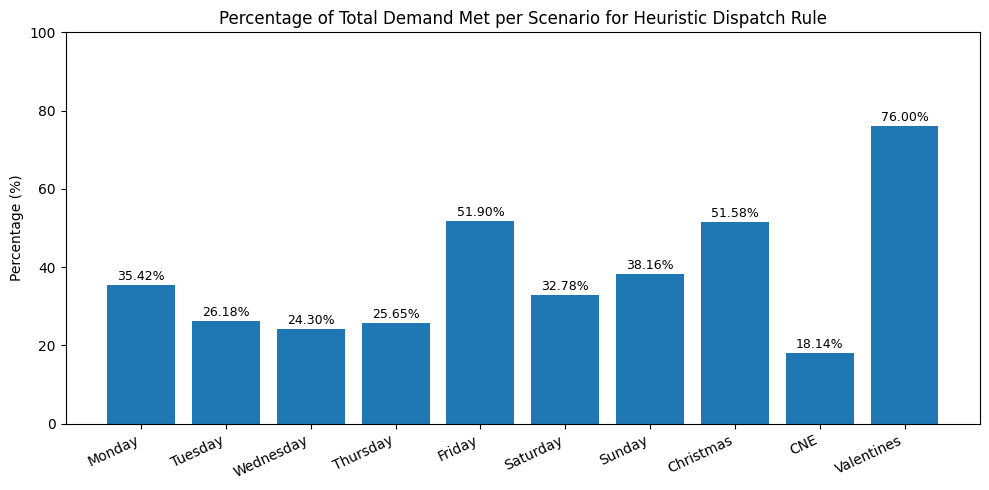

,Scenario,Demand Met %,Passengers Seated,Total Demand
0,Monday,35.422279,36288,102444
1,Tuesday,26.182570,29646,113228
2,Wednesday,24.297845,30132,124011
3,Thursday,25.652421,29322,114305
4,Friday,51.897360,49248,94895
5,Saturday,32.776935,19440,59310
6,Sunday,38.158651,20574,53917
7,Christmas,51.578402,66744,129403
8,CNE,18.139076,32562,179513
9,Valentines,75.995621,99954,131526


In [126]:
metrics_df = percent_demand_met_for_profiles(
    instances,
    PROFILES,
    heuristic_dispatch2,
    generate_scenario,
    dispatch_name="Heuristic Dispatch Rule"
)
metrics_df


=== Dispatch Schedule for Monday ===

=== Dispatch Schedule for Tuesday ===

=== Dispatch Schedule for Wednesday ===

=== Dispatch Schedule for Thursday ===

=== Dispatch Schedule for Friday ===

=== Dispatch Schedule for Saturday ===

=== Dispatch Schedule for Sunday ===

=== Dispatch Schedule for Christmas ===

=== Dispatch Schedule for CNE ===

=== Dispatch Schedule for Valentines ===


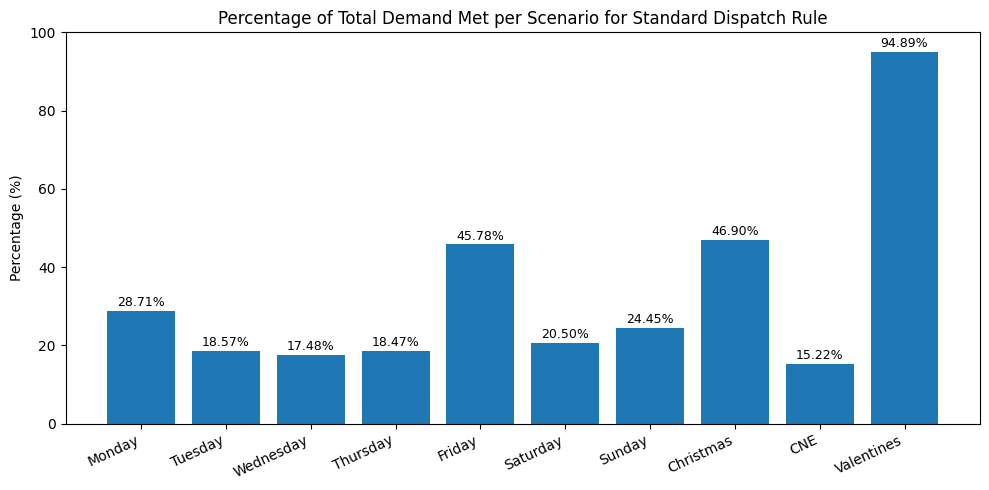

,Scenario,Demand Met %,Passengers Seated,Total Demand
0,Monday,28.710320,29412,102444
1,Tuesday,18.573144,21030,113228
2,Wednesday,17.479901,21677,124011
3,Thursday,18.465509,21107,114305
4,Friday,45.780073,43443,94895
5,Saturday,20.499073,12158,59310
6,Sunday,24.448690,13182,53917
7,Christmas,46.898449,60688,129403
8,CNE,15.220625,27323,179513
9,Valentines,94.885422,124799,131526


In [125]:
metrics_df = percent_demand_met_for_profiles(
    instances,
    PROFILES,
    standard_dispatch,
    generate_scenario,
    dispatch_name="Standard Dispatch Rule"
)
metrics_df

In [94]:
'''
import time
import psutil
import pandas as pd

def evaluate_scenario_performance(instances, dispatch_method="heuristic"):
    """
    Evaluate performance for each pre-generated scenario instance.
    Each key in `instances` (e.g. 'Monday', 'Tuesday', ...) represents one scenario.

    Args:
        instances (dict): Dictionary mapping profile names -> scenario data.
        dispatch_method (str): 'standard' or 'heuristic'.

    Returns:
        pd.DataFrame: Performance metrics per scenario.
    """
    if dispatch_method not in ["standard", "heuristic"]:
        raise ValueError("Invalid dispatch method. Choose 'standard' or 'heuristic'.")

    results = []

    for profile_name, scenario in instances.items():
        start_time = time.time()
        start_mem = psutil.Process().memory_info().rss

        # Run the chosen dispatch algorithm
        if dispatch_method == "heuristic":
            df = heuristic_dispatch2(scenario, profile_name=profile_name)
        else:
            df = standard_dispatch(scenario, profile_name=profile_name)

        elapsed = time.time() - start_time
        mem_used = psutil.Process().memory_info().rss - start_mem

        # Handle both string or datetime 'Time' columns
        if pd.api.types.is_datetime64_any_dtype(df["Time"]):
            mask = df["Time"].dt.strftime("%H:%M").isin(["5:55", "05:55"])
        else:
            mask = df["Time"].astype(str).isin(["5:55", "05:55"])

        objective_value = df.loc[mask, "Objective Value"].sum()

        results.append({
            "Profile Name": profile_name,
            "Objective Value @ 5:55": objective_value,
            "Computational Time (seconds)": elapsed,
            "Memory Consumption (MB)": mem_used / (1024 * 1024)
        })

        print(f"Scenario: {profile_name}")
        print(f"Objective Value @ 5:55: {objective_value}")
        print(f"Computational Time: {elapsed:.4f} s")
        print(f"Memory Consumption: {mem_used / (1024 * 1024):.2f} MB\n")

    return pd.DataFrame(results)
'''

'\nimport time\nimport psutil\nimport pandas as pd\n\ndef evaluate_scenario_performance(instances, dispatch_method="heuristic"):\n    """\n    Evaluate performance for each pre-generated scenario instance.\n    Each key in `instances` (e.g. \'Monday\', \'Tuesday\', ...) represents one scenario.\n\n    Args:\n        instances (dict): Dictionary mapping profile names -> scenario data.\n        dispatch_method (str): \'standard\' or \'heuristic\'.\n\n    Returns:\n        pd.DataFrame: Performance metrics per scenario.\n    """\n    if dispatch_method not in ["standard", "heuristic"]:\n        raise ValueError("Invalid dispatch method. Choose \'standard\' or \'heuristic\'.")\n\n    results = []\n\n    for profile_name, scenario in instances.items():\n        start_time = time.time()\n        start_mem = psutil.Process().memory_info().rss\n\n        # Run the chosen dispatch algorithm\n        if dispatch_method == "heuristic":\n            df = heuristic_dispatch2(scenario, profile_name=

In [95]:
'''
# assuming you already did
instances = get_instances()

# run evaluation
perf_heuristic = evaluate_scenario_performance(instances, dispatch_method="heuristic")
perf_standard  = evaluate_scenario_performance(instances, dispatch_method="standard")

print("\nHeuristic Dispatch Performance:")
print(perf_heuristic)

print("\nStandard Dispatch Performance:")
print(perf_standard)
'''

'\n# assuming you already did\ninstances = get_instances()\n\n# run evaluation\nperf_heuristic = evaluate_scenario_performance(instances, dispatch_method="heuristic")\nperf_standard  = evaluate_scenario_performance(instances, dispatch_method="standard")\n\nprint("\nHeuristic Dispatch Performance:")\nprint(perf_heuristic)\n\nprint("\nStandard Dispatch Performance:")\nprint(perf_standard)\n'

In [96]:
'''
import time
import psutil
import pandas as pd

def evaluate_scenario_performance(instances, dispatch_method="heuristic"):
    """
    Evaluate performance for each pre-generated scenario (instance) and
    return a summary of the results.

    Args:
        instances (dict): Dictionary mapping scenario name -> scenario data
                          (e.g., {"Monday": scenario_dict, "Tuesday": scenario_dict, ...})
        dispatch_method (str): The dispatch method to use: 'standard' or 'heuristic'.

    Returns:
        pd.DataFrame: DataFrame with performance metrics for all scenarios.
    """
    # Validate method
    if dispatch_method not in ["standard", "heuristic"]:
        raise ValueError("Invalid dispatch method. Choose 'standard' or 'heuristic'.")

    results = []

    for scenario_name, scenario_data in instances.items():
        print(f"Running scenario: {scenario_name}")

        # Track time and memory usage
        start_time = time.time()
        start_mem = psutil.Process().memory_info().rss

        # Choose dispatch method
        if dispatch_method == "heuristic":
            df = heuristic_dispatch2(scenario_data, profile_name=scenario_name)
        else:
            df = standard_dispatch(scenario_data, profile_name=scenario_name)

        # Compute performance metrics
        elapsed_time = time.time() - start_time
        mem_used = psutil.Process().memory_info().rss - start_mem

        # Objective value at 5:55
        if pd.api.types.is_datetime64_any_dtype(df["Time"]):
            mask = df["Time"].dt.strftime("%H:%M").isin(["5:55", "05:55"])
        else:
            mask = df["Time"].astype(str).isin(["5:55", "05:55"])
        objective_value = df.loc[mask, "Objective Value"].sum()

        # Store results
        results.append({
            "Profile Name": scenario_name,
            "Objective Value @ 5:55": objective_value,
            "Computational Time (seconds)": elapsed_time,
            "Memory Consumption (MB)": mem_used / (1024 * 1024)
        })

        # Print summary for each scenario
        print(f"Scenario: {scenario_name}")
        print(f"Objective Value @ 5:55: {objective_value}")
        print(f"Computational Time: {elapsed_time:.4f} s")
        print(f"Memory Consumption: {mem_used / (1024 * 1024):.2f} MB\n")

    # Convert to DataFrame
    return pd.DataFrame(results)
'''

'\nimport time\nimport psutil\nimport pandas as pd\n\ndef evaluate_scenario_performance(instances, dispatch_method="heuristic"):\n    """\n    Evaluate performance for each pre-generated scenario (instance) and\n    return a summary of the results.\n\n    Args:\n        instances (dict): Dictionary mapping scenario name -> scenario data\n                          (e.g., {"Monday": scenario_dict, "Tuesday": scenario_dict, ...})\n        dispatch_method (str): The dispatch method to use: \'standard\' or \'heuristic\'.\n\n    Returns:\n        pd.DataFrame: DataFrame with performance metrics for all scenarios.\n    """\n    # Validate method\n    if dispatch_method not in ["standard", "heuristic"]:\n        raise ValueError("Invalid dispatch method. Choose \'standard\' or \'heuristic\'.")\n\n    results = []\n\n    for scenario_name, scenario_data in instances.items():\n        print(f"Running scenario: {scenario_name}")\n\n        # Track time and memory usage\n        start_time = time.

In [97]:
'''
# Pre-generate scenarios
instances = get_instances()  # your helper returns dict of 10 profiles

# Evaluate both methods
performance_df_heuristic = evaluate_scenario_performance(instances, dispatch_method="heuristic")
performance_df_standard  = evaluate_scenario_performance(instances, dispatch_method="standard")

print("\nHeuristic Dispatch Performance:")
print(performance_df_heuristic)

print("\nStandard Dispatch Performance:")
print(performance_df_standard)
'''

'\n# Pre-generate scenarios\ninstances = get_instances()  # your helper returns dict of 10 profiles\n\n# Evaluate both methods\nperformance_df_heuristic = evaluate_scenario_performance(instances, dispatch_method="heuristic")\nperformance_df_standard  = evaluate_scenario_performance(instances, dispatch_method="standard")\n\nprint("\nHeuristic Dispatch Performance:")\nprint(performance_df_heuristic)\n\nprint("\nStandard Dispatch Performance:")\nprint(performance_df_standard)\n'

In [98]:
'''
# Run dispatch only for Christmas
christmas_scenario = instances["Christmas"]
heuristic_dispatch2(christmas_scenario, profile_name="Christmas")
'''

'\n# Run dispatch only for Christmas\nchristmas_scenario = instances["Christmas"]\nheuristic_dispatch2(christmas_scenario, profile_name="Christmas")\n'

In [99]:
'''
print_schedule_summary(df)
'''

'\nprint_schedule_summary(df)\n'